In [ ]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/1297rohit/RCNN.git
! git pull origin master
# ! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 4), reused 3 (delta 3), pack-reused 19
Unpacking objects: 100% (25/25), 12.60 MiB | 6.77 MiB/s, done.
From https://github.com/1297rohit/RCNN
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
!unzip Images.zip
!unzip Airplanes_Annotations.zip



Archive:  Images.zip
   creating: Images/
  inflating: Images/airplane_007.jpg  
  inflating: Images/airplane_006.jpg  
  inflating: Images/airplane_005.jpg  
  inflating: Images/airplane_004.jpg  
  inflating: Images/airplane_003.jpg  
  inflating: Images/airplane_002.jpg  
  inflating: Images/airplane_001.jpg  
  inflating: Images/428503.jpg       
  inflating: Images/428501.jpg       
  inflating: Images/428492.jpg       
  inflating: Images/428491.jpg       
  inflating: Images/428483.jpg       
  inflating: Images/428482.jpg       
  inflating: Images/428481.jpg       
  inflating: Images/428472.jpg       
  inflating: Images/428462.jpg       
  inflating: Images/428461.jpg       
  inflating: Images/428452.jpg       
  inflating: Images/428451.jpg       
  inflating: Images/42850.jpg        
  inflating: Images/42849.jpg        
  inflating: Images/42848.jpg        
  inflating: Images/42847.jpg        
  inflating: Images/airplane_309.jpg  
  inflating: Images/airplane_319.jpg  

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
# ! pip install opencv-contrib-python

airplane_520.jpg


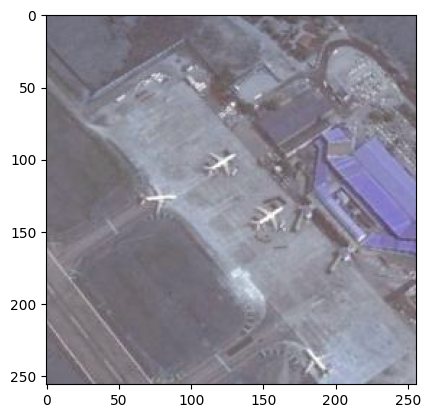

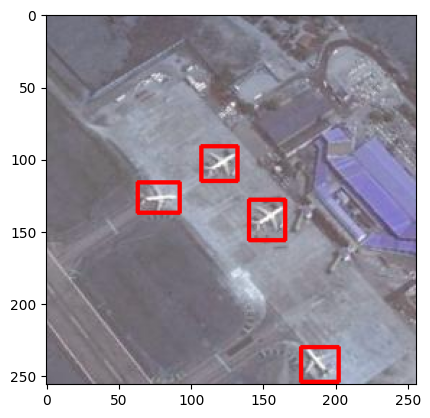

In [ ]:
path = "Images"
annot = "Airplanes_Annotations"
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

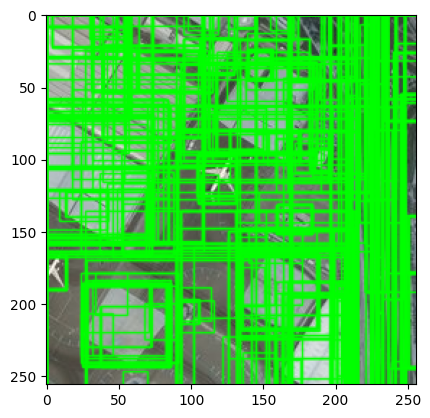

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [ ]:
train_images=[]
train_labels=[]

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou



In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()



for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_520.jpg
1 airplane_227.jpg
2 airplane_357.jpg
3 airplane_187.jpg
4 airplane_106.jpg
5 airplane_162.jpg
6 airplane_067.jpg
7 airplane_596.jpg
inside
9 airplane_133.jpg
10 airplane_464.jpg
11 airplane_238.jpg
12 airplane_270.jpg
13 airplane_593.jpg
inside
14 airplane_540.jpg
15 airplane_695.jpg
16 airplane_333.jpg
17 airplane_640.jpg
18 airplane_119.jpg
inside
19 airplane_203.jpg
20 airplane_026.jpg
21 airplane_389.jpg
22 airplane_644.jpg
23 airplane_674.jpg
24 airplane_625.jpg
25 airplane_655.jpg
26 airplane_070.jpg
27 airplane_296.jpg
28 airplane_594.jpg
29 airplane_189.jpg
30 airplane_383.jpg
inside
31 airplane_220.jpg
32 airplane_280.jpg
33 airplane_091.jpg
34 airplane_164.jpg
35 airplane_530.jpg
36 airplane_325.jpg
37 airplane_391.jpg
38 airplane_684.jpg
39 airplane_660.jpg
40 airplane_002.jpg
41 airplane_223.jpg
inside
42 airplane_517.jpg
43 airplane_550.jpg
44 airplane_057.jpg
45 airplane_059.jpg
46 airplane_038.jpg
48 airplane_318.jpg
49 airplane_671.jpg
50 airplane_20

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

X_new.shape

(30229, 224, 224, 3)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 [==============================] - 28s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(vggmodel.input, predictions)

In [ ]:
# model_final = Model(input = vggmodel.input, output = predictions)

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

<ipython-input-29-ffff19eb1cb4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9344
Epoch 1: val_loss did not improve from 0.07797
10/10 [==============================] - 4s 428ms/step - loss: 0.1629 - accuracy: 0.9344 - val_loss: 0.1571 - val_accuracy: 0.9688
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9406
Epoch 2: val_loss did not improve from 0.07797
10/10 [==============================] - 4s 425ms/step - loss: 0.1570 - accuracy: 0.9406 - val_loss: 0.0943 - val_accuracy: 0.9688
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9500
Epoch 3: val_loss did not improve from 0.07797
10/10 [==============================] - 4s 433ms/step - loss: 0.1566 - accuracy: 0.9500 - val_loss: 0.2855 - val_accuracy: 0.9062
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9531
Epoch 4: val_loss did not improve from 0.07797
10/10 [==============================] 

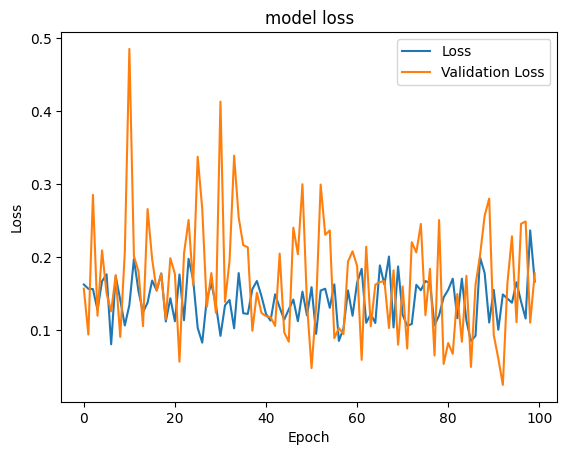

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 1s 1s/step
not plane


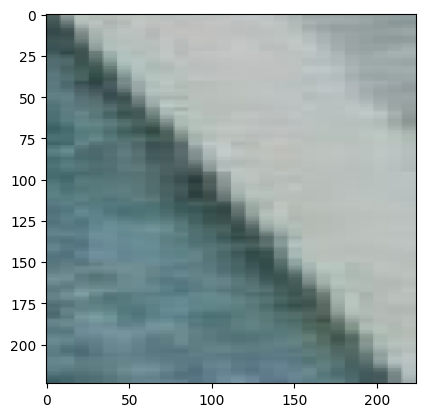

In [ ]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

1/1 [==============================] - 0s 19ms/step
plane


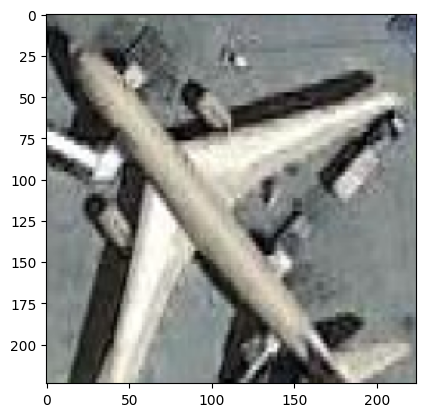

In [ ]:
im = X_test[4]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)

Output hidden; open in https://colab.research.google.com to view.